# Music Genre Classification with CNN

## 1. Importing the Libraries

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sys
import os
import pickle
import librosa
import librosa.display
from IPython.display import Audio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

## Read the csv file

In [22]:
df = pd.read_csv("C:/Users/alexa/Documents/Studium/Bachelor/3secTest.csv", sep=',')
df.head()

,Filename,Zero-cross freq mean,Zero-cross freq var,Tempo,RMS mean,RMS var,Brightness mean,Brightness var,MFCC 1 mean,MFCC 2 mean,...,Kurtness mean,Kurtness var,Flatness mean,Flatness var,Key,Key clarity,Key strength,Pitch mean,Pitch var,label
0,blues.00000_1.wav,906.461514,111177.45990,127.103773,0.129567,0.004048,0.368733,0.005530,2.500534,-0.128866,...,6.000462,3.681079,0.209059,0.003680,6,0.527537,5,225.925686,0.00000,Blues
1,blues.00000_2.wav,1133.455215,95833.26480,124.328052,0.113217,0.002303,0.422351,0.003885,2.229724,-0.275207,...,5.900562,2.227539,0.202205,0.002178,8,0.436210,7,196.160272,34421.80606,Blues
2,blues.00000_3.wav,968.758674,156211.68920,124.674109,0.111471,0.001824,0.396775,0.007755,2.250917,0.074289,...,5.363601,2.772184,0.217900,0.002428,8,0.592456,7,158.873968,2617.84062,Blues
3,blues.00000_4.wav,795.318672,60228.97970,125.730781,0.129128,0.005272,0.378577,0.005374,2.116147,0.089512,...,5.216539,2.587718,0.226502,0.003035,1,0.409354,0,243.087617,24005.03017,Blues
4,blues.00000_5.wav,770.937867,44856.42962,124.667927,0.129709,0.002962,0.331377,0.006673,2.656102,0.056569,...,6.413842,5.461441,0.209709,0.003230,1,0.593686,0,374.900750,34521.94190,Blues


## About Dataset

In [23]:
df.shape

(9990, 76)

In [24]:
df.dtypes

Filename                 object
Zero-cross freq mean    float64
Zero-cross freq var     float64
Tempo                   float64
RMS mean                float64
                         ...   
Key clarity             float64
Key strength              int64
Pitch mean              float64
Pitch var               float64
label                    object
Length: 76, dtype: object

In [25]:
df=df.drop(labels=['Filename'],axis=1)
df=df.dropna(axis=0,how='any')

## Understanding Audio

In [26]:
audio_recordings="C:/Users/alexa/Documents/Studium/Bachelor/Data2/genres_original/classical/classical.00000.wav"
audio,sr=librosa.load(audio_recordings)
print(type(audio), type(sr))

<class 'numpy.ndarray'> <class 'int'>


In [27]:
librosa.load(audio_recordings, sr=45600)

(array([-0.0198018 , -0.02405333, -0.01842372, ...,  0.03486316,
         0.02950384,  0.01502028], dtype=float32),
 45600)

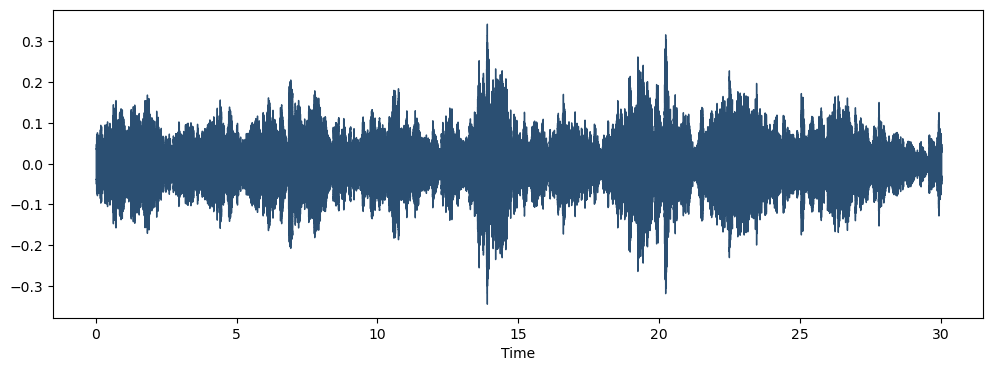

In [28]:
plt.figure(figsize=(12,4))
librosa.display.waveshow(audio,color="#2B4F72")
plt.show()

C:\Users\alexa\anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  return f(*args, **kwargs)


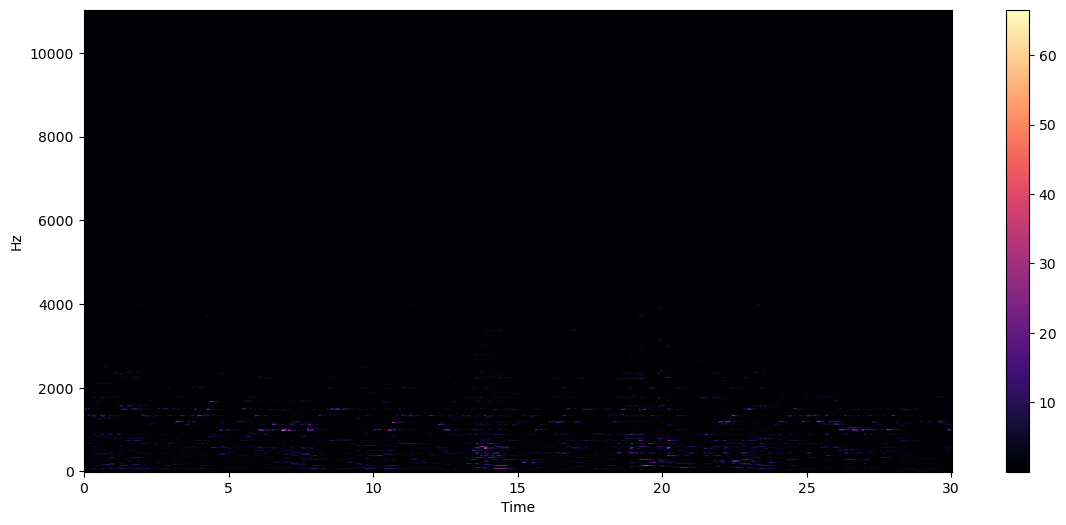

In [29]:
stft = librosa.stft(audio)
stft_db = librosa.amplitude_to_db(abs(stft))
plt.figure(figsize=(14,6))
librosa.display.specshow(stft,sr=sr,x_axis='time',y_axis='hz')
plt.colorbar()

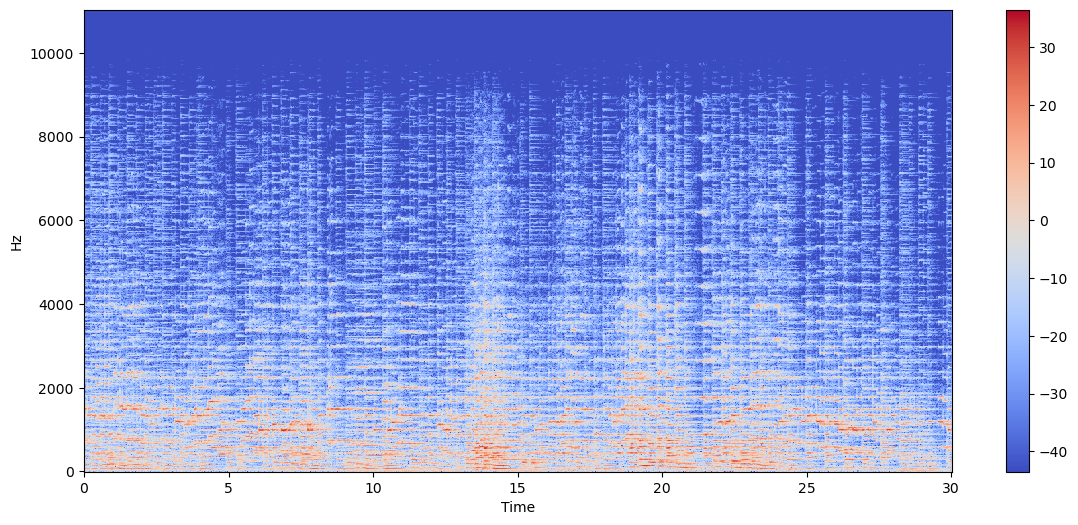

In [30]:
stft = librosa.stft(audio)
stft_db = librosa.amplitude_to_db(abs(stft))
plt.figure(figsize=(14,6))
librosa.display.specshow(stft_db,sr=sr,x_axis='time',y_axis='hz')
plt.colorbar()

C:\Users\alexa\AppData\Local\Temp\ipykernel_38056\1419995392.py:2: FutureWarning: Pass y=[-0.01008057 -0.00748657  0.01418091 ...  0.02934814  0.03777099
  0.04131103] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_rolloff = librosa.feature.spectral_rolloff(audio+0.01,sr=sr)[0]


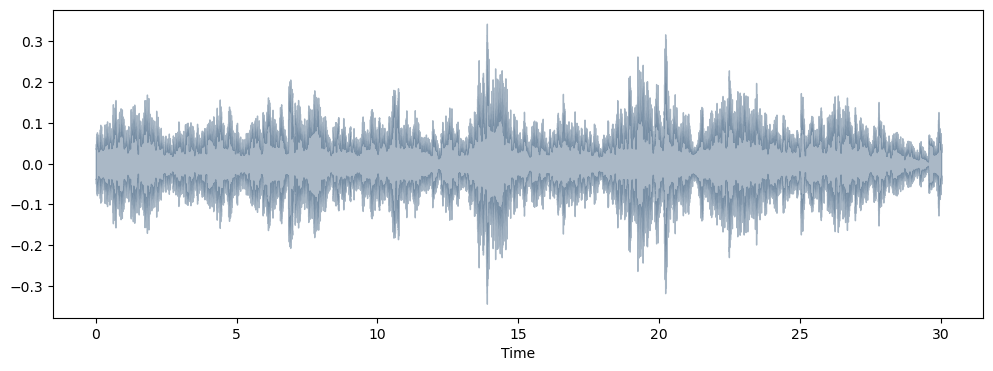

In [31]:
from sklearn.preprocessing import normalize
spectral_rolloff = librosa.feature.spectral_rolloff(audio+0.01,sr=sr)[0]
plt.figure(figsize=(12,4))
librosa.display.waveshow(audio, sr=sr, alpha = 0.4, color="#2B4F72")

C:\Users\alexa\AppData\Local\Temp\ipykernel_38056\2621745964.py:2: FutureWarning: Pass y=[-0.02008057 -0.01748657  0.00418091 ...  0.01934814  0.027771
  0.03131104] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  chroma=librosa.feature.chroma_stft(audio, sr=sr)


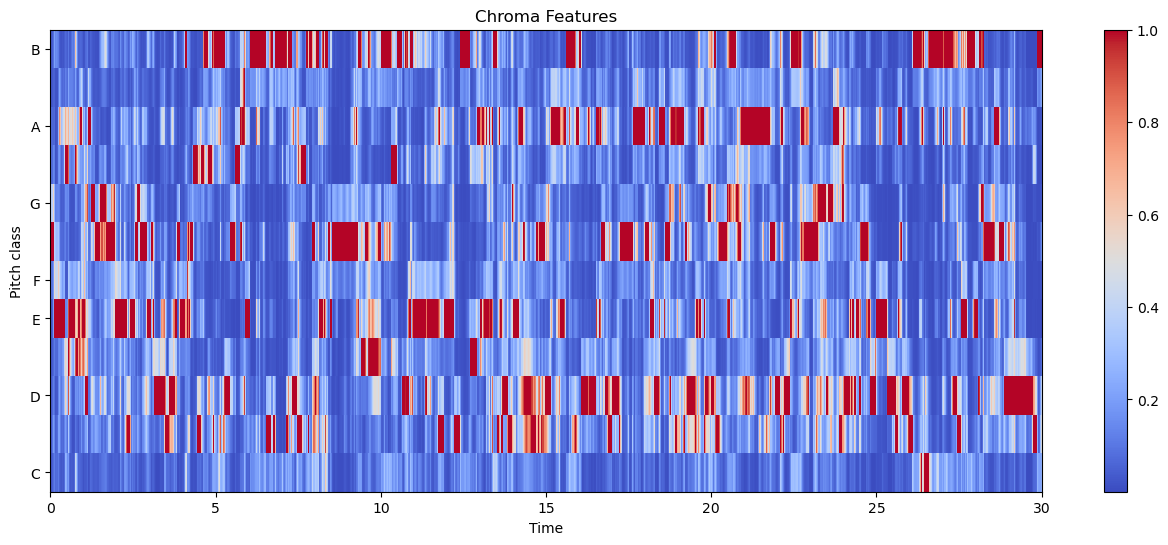

In [32]:
import librosa.display as lplt
chroma=librosa.feature.chroma_stft(audio, sr=sr)
plt.figure(figsize=(16,6))
lplt.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma', cmap='coolwarm')
plt.colorbar()
plt.title("Chroma Features")
plt.show()

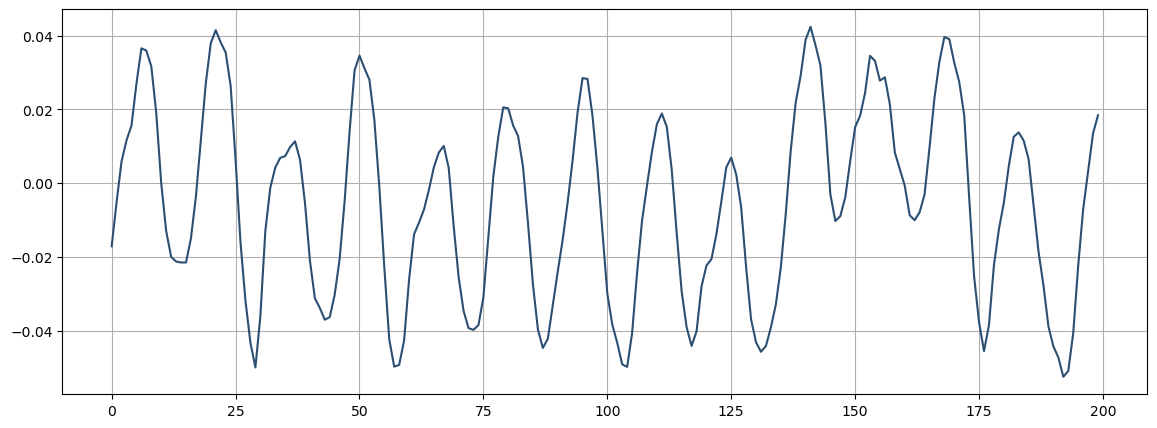

In [33]:
start=1000
end=1200
plt.figure(figsize=(14,5))
plt.plot(audio[start:end], color="#2B4F72")
plt.grid()

In [34]:
zero_cross_rate=librosa.zero_crossings(audio[start:end], pad=False)
print("The number of zero-crossings is :", sum(zero_cross_rate))

The number of zero-crossings is : 27


## Feature Extraction

In [35]:
class_list = df.iloc[:,-1]
convertor = LabelEncoder()

In [36]:
y = convertor.fit_transform(class_list)
y



array([0, 0, 0, ..., 9, 9, 9])

In [37]:
print(df.iloc[:,:-1])




      Zero-cross freq mean  Zero-cross freq var       Tempo  RMS mean  \
0               906.461514         111177.45990  127.103773  0.129567   
1              1133.455215          95833.26480  124.328052  0.113217   
2               968.758674         156211.68920  124.674109  0.111471   
3               795.318672          60228.97970  125.730781  0.129128   
4               770.937867          44856.42962  124.667927  0.129709   
...                    ...                  ...         ...       ...   
9985            654.162218          55402.96826  126.925559  0.048823   
9986            808.686079          89712.40305  139.773346  0.049793   
9987            991.710259         141441.06660   81.679594  0.057970   
9988            804.902850         489148.22870  123.702227  0.051931   
9989           1153.380218         243344.64170   87.528648  0.066060   

       RMS var  Brightness mean  Brightness var  MFCC 1 mean  MFCC 2 mean  \
0     0.004048         0.368733        0.00553

In [38]:
from sklearn.preprocessing import StandardScaler
fit=StandardScaler()
X=fit.fit_transform(np.array(df.iloc[:,:-1], dtype = float))
X

array([[-0.27319035, -0.46244917,  0.09167758, ..., -0.17192833,
        -0.81156955, -0.47238749],
       [ 0.22735528, -0.51579252,  0.00405234, ...,  0.39867334,
        -0.90775276, -0.26374256],
       [-0.13581839, -0.30588988,  0.01497685, ...,  0.39867334,
        -1.02823878, -0.45651967],
       ...,
       [-0.08520766, -0.35723923, -1.34229373, ...,  1.53987666,
        -0.2929371 ,  0.35098966],
       [-0.49713818,  0.8515477 , -0.01570397, ..., -0.45722916,
        -0.26796857,  1.7126729 ],
       [ 0.27129206, -0.00297644, -1.15764811, ..., -0.45722916,
         0.05693898,  0.82428533]])

## Dividing Data into training and testing sets

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20)
len(y_train)

6287

In [40]:
len(y_test)

1572

## Building the model

In [41]:
from keras.models import Sequential

In [44]:
def training(model, epochs, optimizer):
    batch_size = 32
    model.compile(optimizer=optimizer,
                 loss='sparse_categorical_crossentropy',
                 metrics='accuracy')
    mc=ModelCheckpoint("Dataframe_model.h5", monitor='val_accuracy',mode='max',save_best_only=True)
    return model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=epochs, batch_size=batch_size,callbacks=[mc])

In [45]:
def plotValidate(history):
    print("Validation Accuracy", max(history.history["val_accuracy"]))
    pd.DataFrame(history.history).plot(figsize=(12,6))
    plt_show()

In [46]:
model = keras.models.Sequential([
    keras.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.5),
    
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.5),
    
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    
    keras.layers.Dense(10, activation='softmax'),
])
print(model.summary())
model_history = training(model=model, epochs=600, optimizer='adam')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               38400     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8

Epoch 47/600
197/197 [==============================] - 1s 4ms/step - loss: 0.4374 - accuracy: 0.8720 - val_loss: 0.5130 - val_accuracy: 0.8683
Epoch 48/600
197/197 [==============================] - 1s 4ms/step - loss: 0.4407 - accuracy: 0.8693 - val_loss: 0.5403 - val_accuracy: 0.8588
Epoch 49/600
197/197 [==============================] - 1s 4ms/step - loss: 0.4388 - accuracy: 0.8678 - val_loss: 0.5736 - val_accuracy: 0.8422
Epoch 50/600
197/197 [==============================] - 1s 4ms/step - loss: 0.4195 - accuracy: 0.8721 - val_loss: 0.5248 - val_accuracy: 0.8581
Epoch 51/600
197/197 [==============================] - 1s 4ms/step - loss: 0.4415 - accuracy: 0.8747 - val_loss: 0.5162 - val_accuracy: 0.8607
Epoch 52/600
197/197 [==============================] - 1s 4ms/step - loss: 0.4302 - accuracy: 0.8718 - val_loss: 0.5055 - val_accuracy: 0.8588
Epoch 53/600
197/197 [==============================] - 1s 4ms/step - loss: 0.4005 - accuracy: 0.8831 - val_loss: 0.5132 - val_accuracy:

Epoch 104/600
197/197 [==============================] - 1s 4ms/step - loss: 0.2782 - accuracy: 0.9209 - val_loss: 0.5174 - val_accuracy: 0.8798
Epoch 105/600
197/197 [==============================] - 1s 4ms/step - loss: 0.2692 - accuracy: 0.9195 - val_loss: 0.5315 - val_accuracy: 0.8747
Epoch 106/600
197/197 [==============================] - 1s 4ms/step - loss: 0.2716 - accuracy: 0.9238 - val_loss: 0.5160 - val_accuracy: 0.8683
Epoch 107/600
197/197 [==============================] - 1s 4ms/step - loss: 0.2535 - accuracy: 0.9292 - val_loss: 0.5537 - val_accuracy: 0.8747
Epoch 108/600
197/197 [==============================] - 1s 4ms/step - loss: 0.2502 - accuracy: 0.9254 - val_loss: 0.5447 - val_accuracy: 0.8715
Epoch 109/600
197/197 [==============================] - 1s 4ms/step - loss: 0.2482 - accuracy: 0.9329 - val_loss: 0.5172 - val_accuracy: 0.8779
Epoch 110/600
197/197 [==============================] - 1s 4ms/step - loss: 0.2562 - accuracy: 0.9297 - val_loss: 0.5393 - val_ac

197/197 [==============================] - 1s 4ms/step - loss: 0.1775 - accuracy: 0.9516 - val_loss: 0.5798 - val_accuracy: 0.8925
Epoch 217/600
197/197 [==============================] - 1s 4ms/step - loss: 0.1729 - accuracy: 0.9556 - val_loss: 0.5867 - val_accuracy: 0.8861
Epoch 218/600
197/197 [==============================] - 1s 4ms/step - loss: 0.1753 - accuracy: 0.9542 - val_loss: 0.5837 - val_accuracy: 0.8880
Epoch 219/600
197/197 [==============================] - 1s 4ms/step - loss: 0.1669 - accuracy: 0.9542 - val_loss: 0.6052 - val_accuracy: 0.8919
Epoch 220/600
197/197 [==============================] - 1s 4ms/step - loss: 0.1812 - accuracy: 0.9532 - val_loss: 0.6112 - val_accuracy: 0.8849
Epoch 221/600
197/197 [==============================] - 1s 4ms/step - loss: 0.1553 - accuracy: 0.9569 - val_loss: 0.6490 - val_accuracy: 0.8842
Epoch 222/600
197/197 [==============================] - 1s 4ms/step - loss: 0.1655 - accuracy: 0.9563 - val_loss: 0.6178 - val_accuracy: 0.8868

197/197 [==============================] - 1s 4ms/step - loss: 0.1356 - accuracy: 0.9656 - val_loss: 0.6555 - val_accuracy: 0.8817
Epoch 329/600
197/197 [==============================] - 1s 4ms/step - loss: 0.1487 - accuracy: 0.9644 - val_loss: 0.6537 - val_accuracy: 0.8880
Epoch 330/600
197/197 [==============================] - 1s 4ms/step - loss: 0.1381 - accuracy: 0.9666 - val_loss: 0.6233 - val_accuracy: 0.8804
Epoch 331/600
197/197 [==============================] - 1s 4ms/step - loss: 0.1508 - accuracy: 0.9641 - val_loss: 0.5681 - val_accuracy: 0.8899
Epoch 332/600
197/197 [==============================] - 1s 4ms/step - loss: 0.1278 - accuracy: 0.9674 - val_loss: 0.6611 - val_accuracy: 0.8849
Epoch 333/600
197/197 [==============================] - 1s 4ms/step - loss: 0.1327 - accuracy: 0.9647 - val_loss: 0.6230 - val_accuracy: 0.8861
Epoch 334/600
197/197 [==============================] - 1s 4ms/step - loss: 0.1231 - accuracy: 0.9674 - val_loss: 0.6695 - val_accuracy: 0.8823

197/197 [==============================] - 1s 4ms/step - loss: 0.1413 - accuracy: 0.9691 - val_loss: 0.5505 - val_accuracy: 0.8957
Epoch 441/600
197/197 [==============================] - 1s 4ms/step - loss: 0.1155 - accuracy: 0.9707 - val_loss: 0.5855 - val_accuracy: 0.8982
Epoch 442/600
197/197 [==============================] - 1s 5ms/step - loss: 0.1123 - accuracy: 0.9704 - val_loss: 0.5976 - val_accuracy: 0.8944
Epoch 443/600
197/197 [==============================] - 1s 5ms/step - loss: 0.1054 - accuracy: 0.9733 - val_loss: 0.6467 - val_accuracy: 0.8957
Epoch 444/600
197/197 [==============================] - 1s 5ms/step - loss: 0.1165 - accuracy: 0.9733 - val_loss: 0.6234 - val_accuracy: 0.8938
Epoch 445/600
197/197 [==============================] - 1s 4ms/step - loss: 0.1096 - accuracy: 0.9738 - val_loss: 0.6292 - val_accuracy: 0.8989
Epoch 446/600
197/197 [==============================] - 1s 4ms/step - loss: 0.1160 - accuracy: 0.9752 - val_loss: 0.6498 - val_accuracy: 0.8982

197/197 [==============================] - 1s 4ms/step - loss: 0.1181 - accuracy: 0.9752 - val_loss: 0.6681 - val_accuracy: 0.8969
Epoch 553/600
197/197 [==============================] - 1s 4ms/step - loss: 0.1106 - accuracy: 0.9723 - val_loss: 0.7312 - val_accuracy: 0.8982
Epoch 554/600
197/197 [==============================] - 1s 4ms/step - loss: 0.1188 - accuracy: 0.9758 - val_loss: 0.6669 - val_accuracy: 0.8982
Epoch 555/600
197/197 [==============================] - 1s 4ms/step - loss: 0.0901 - accuracy: 0.9773 - val_loss: 0.7038 - val_accuracy: 0.9033
Epoch 556/600
197/197 [==============================] - 1s 4ms/step - loss: 0.1050 - accuracy: 0.9752 - val_loss: 0.7027 - val_accuracy: 0.9027
Epoch 557/600
197/197 [==============================] - 1s 4ms/step - loss: 0.0835 - accuracy: 0.9808 - val_loss: 0.6906 - val_accuracy: 0.9065
Epoch 558/600
197/197 [==============================] - 1s 4ms/step - loss: 0.0940 - accuracy: 0.9769 - val_loss: 0.6992 - val_accuracy: 0.9020

## Model Evaluation

In [47]:
test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=32)
print("The test loss is :",test_loss)
print("\nThe Best test accuracy is :", test_acc*100)
#print("\nSaving model...")
#model.save("C:/Users/alexa/Documents/Studium/Bachelor/saved_models/Dataframe_model.hdf5")

50/50 [==============================] - 0s 2ms/step - loss: 0.6487 - accuracy: 0.8938
The test loss is : 0.6486940383911133

The Best test accuracy is : 89.3765926361084


In [48]:
pred=model.predict(X_test,verbose=1)

50/50 [==============================] - 0s 2ms/step


Validation Accuracy 0.9090330600738525


NameError: name 'plt_show' is not defined

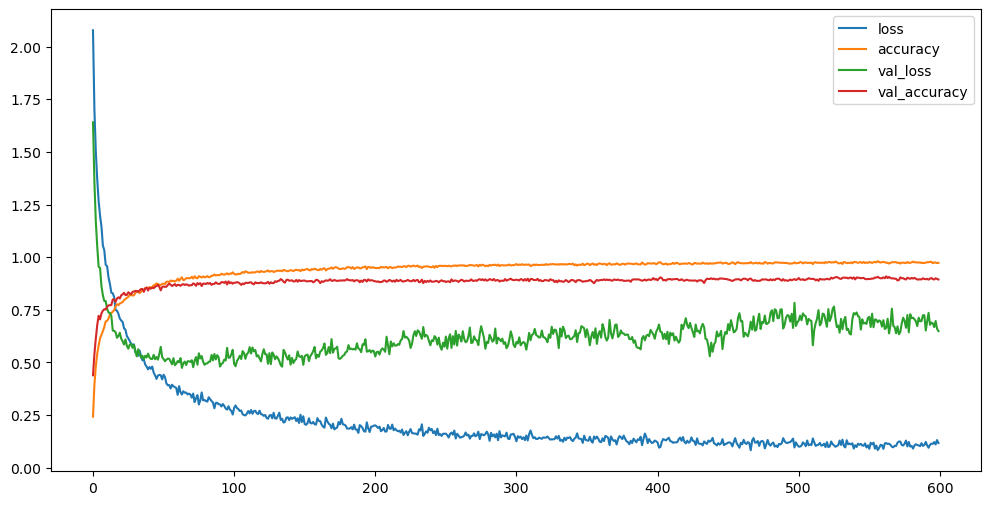

In [49]:
plotValidate(model_history)

In [45]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=False,title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm=cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")
        
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks,classes)
    
    fmt='.2f' if normalize else 'd'
    thresh = cm.max()/2
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
            

Confusion Matrix Calculating ...
50/50 [==============================] - 1s 8ms/step
Normalized confusion matrix


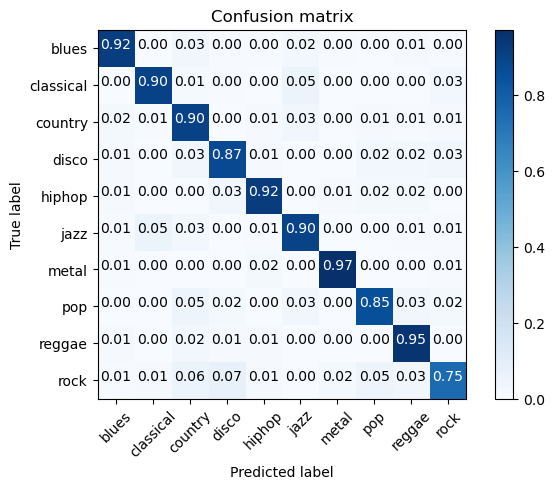

In [49]:
from collections import OrderedDict

print('Confusion Matrix Calculating ...')
preds = np.argmax(model.predict(X_test),axis=1)
y_orig = y_test
cm = confusion_matrix(preds, y_orig)

genres={'blues':0, 'classical':1, 'country':2, 'disco':3, 'hiphop':4, 'jazz':5, 'metal':6, 'pop':7, 'reggae':8, 'rock':9}
keys = OrderedDict(sorted(genres.items(), key=lambda t: t[1])).keys()

plot_confusion_matrix(cm,keys,normalize=True)
plt.show()

In [58]:
dtest=pd.read_csv("C:/Users/alexa/Documents/Studium/Bachelor/Testsong3sec.csv", sep=',')
dtest=dtest.drop(labels=['Filename'],axis=1)
dtest
X2=dtest.drop(labels=['label'],axis=1)
X2
#class_list2 = dtest.iloc[:,-1]
#convertor = LabelEncoder()
#y2 = convertor.fit_transform(class_list2)
#fit2=StandardScaler()
#X2=fit2.fit_transform(np.array(df.iloc[:,:-1], dtype = float))

,Zero-cross freq mean,Zero-cross freq var,Tempo,RMS mean,RMS var,Brightness mean,Brightness var,MFCC 1 mean,MFCC 2 mean,MFCC 3 mean,...,Skewness var,Kurtness mean,Kurtness var,Flatness mean,Flatness var,Key,Key clarity,Key strength,Pitch mean,Pitch var
0,1147.831483,55610.93352,118.872607,0.095718,0.000326,0.439469,0.00437,2.200766,-0.302438,0.803905,...,0.098805,5.086097,1.868948,0.226882,0.002843,3,0.875557,2,137.148304,3368.129626


In [59]:
prediction=model.predict(X2)

1/1 [==============================] - 0s 62ms/step


In [60]:
print(prediction)

[[0.03464295 0.02632003 0.214753   0.14270148 0.03038535 0.04680487
  0.03601174 0.04146212 0.10057959 0.32633886]]


In [61]:
classes=np.argmax(prediction,axis=1)
print(classes)

[9]


## References

Chowdhry, A. (2021, May 7). Music Genre Classification Using CNN. Clairvoyant. Retrieved April 14, 2023, from https://www.clairvoyant.ai/blog/music-genre-classification-using-cnn

From: Ahmad, F., & Sahil, N. (2019) Plot_CM.py [Source Code] (Accessed April 23, 2023) https://github.com/sahilsharma884/Music-Genre-Classification/blob/master/Plot_CM.py

From: Ahmad, F., & Sahil, N. (2019) CNN_Model.py [Source Code] (Accessed April 23, 2023) https://github.com/sahilsharma884/Music-Genre-Classification/blob/master/CNN_Model.py